**CDS REPORT**

Notebook for data training.


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# root_dir_image = '/content/gdrive/My Drive/Colab Notebooks/Flicker8k_Dataset'
# root_dir_text = '/content/gdrive/My Drive/Colab Notebooks/Text_Files'
# root_captioning = 'C:/Users/Asus/Documents/GitHub/CDS2019/project'

root_dir_image = '.\\Flicker8k_Dataset'
root_dir_text = '.\\Text_Files'
root_captioning = ''

# print('Note: using Google CoLab')
# COLAB = True

Here, InceptionV3 is used in order to extract the features of the images from the flickr 8k dataset

In [2]:
# %tensorflow_version 2.x

import os
import string
import glob
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

Importing the necessary libraries for data training

In [3]:
from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [5]:
def clean_caption_text():
  null_punct = str.maketrans('', '', string.punctuation)
  lookup = dict()
  with open( os.path.join(root_captioning,'Text_Files','Flickr8k.token.txt'), 'r') as fp:
    max_length = 0
    for line in fp.read().split('\n'):
      tok = line.split()
      if len(line) >= 2:
        id = tok[0].split('.')[0]
        desc = tok[1:]
        
        # Cleanup description
        desc = [word.lower() for word in desc]
        desc = [w.translate(null_punct) for w in desc]
        desc = [word for word in desc if len(word)>1]
        desc = [word for word in desc if word.isalpha()]
        max_length = max(max_length,len(desc))
        
        if id not in lookup:
          lookup[id] = list()
        lookup[id].append(' '.join(desc))
        
  lex = set()
  for key in lookup:
    [lex.update(d.split()) for d in lookup[key]]

  return lookup, lex, max_length

In [6]:
lookup, lex, max_length = clean_caption_text()

In [7]:
print('Sanity check for the dataset to make sure they are cleaned properly\n')

print(f'The number of unique words in the dataset: {len(lookup)}')
print(f'The length of dictionary: {len(lex)}') 
print(f'The maximum length of a caption: {max_length}')

Sanity check for the dataset to make sure they are cleaned properly

The number of unique words in the dataset: 8092
The length of dictionary: 8763
The maximum length of a caption: 32


In [8]:
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))
print(f'Number of images in the dataset: {len(img)}')

Number of images in the dataset: 8109


In [9]:
print('Loading test and train captions\n')
train_images_path = os.path.join(root_captioning,'Text_Files','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Text_Files','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)
print(f'Training Captions: {train_img}')
print(f'Testing Captions: {test_img}')

Loading test and train captions

Training Captions: ['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032460886_4a598ed535.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1048710776_bb5b0a5c7c.jpg', '1052358063_eae6744153.jpg', '105342180_4d4a40b47f.jpg'

In [10]:
print('Start building caption sequences')

train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'
print(f'The Sequences are: {v}')

Start building caption sequences
The Sequences are: ['startseq person stands near golden walls endseq', 'startseq woman behind scrolled wall is writing endseq', 'startseq woman standing near decorated wall writes endseq', 'startseq the walls are covered in gold and patterns endseq', 'startseq woman writing on pad in room with gold decorated walls endseq']


In [11]:
if USE_INCEPTION:
  name ='inception'
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  pass

In [12]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:

def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [14]:
train_path = os.path.join(root_captioning,f'train{OUTPUT_DIM}.pkl')
print(train_path)

train2048.pkl


In [15]:
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [16]:
test_path = os.path.join(root_captioning,f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  # print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

In [17]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
print(len(all_train_captions))

30000


In [18]:
word_count_threshold = 25
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 931


In [19]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
print(vocab_size)
max_length +=2
print(max_length)

932
34


DATA GENERATOR

In [20]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [21]:
glove_dir = os.path.join(root_captioning,'glob.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.840B.300d.txt'), encoding="utf-8")
try:
  for line in tqdm(f):
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
except ValueError:
  pass

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

51223it [00:04, 11572.42it/s]

Found 52343 word vectors.


In [22]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(932, 300)


In [23]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [24]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 300)      279600      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [25]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['accuracy'])

In [26]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [27]:
!pip install pydot
!pip install graphviz
from tensorflow.keras.utils import plot_model
plot_model(caption_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


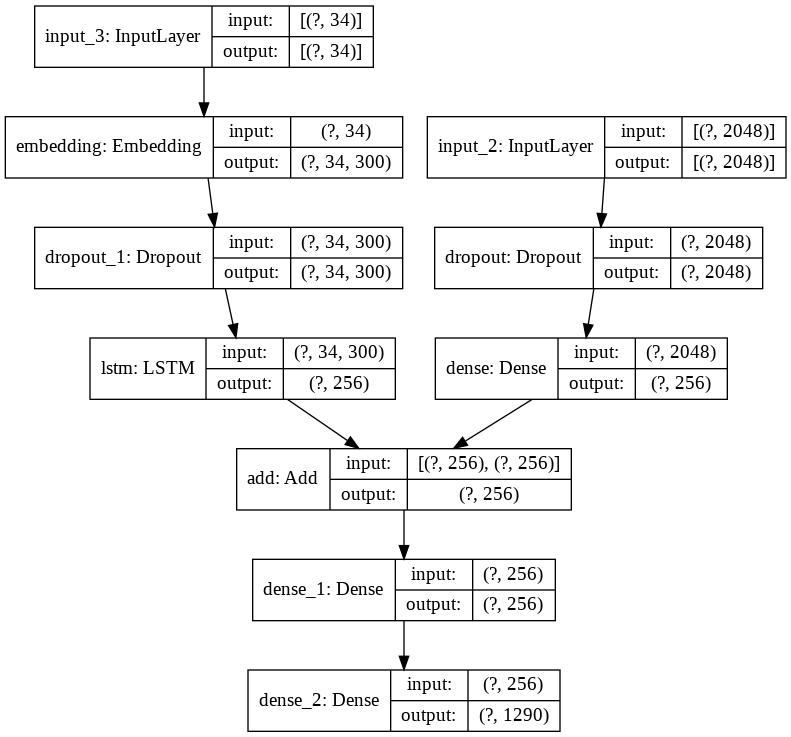

In [ ]:
model_path = os.path.join(root_captioning,f'caption-model{word_count_threshold}-300.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  # print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

2000/2000 [==============================] - 236s 118ms/step - loss: 3.8149 - accuracy: 0.2561


  5%|████                                                                            | 1/20 [03:55<1:14:39, 235.75s/it]

2000/2000 [==============================] - 234s 117ms/step - loss: 3.1978 - accuracy: 0.3079


 10%|████████                                                                        | 2/20 [07:49<1:10:32, 235.14s/it]

2000/2000 [==============================] - 236s 118ms/step - loss: 3.0183 - accuracy: 0.3268


 15%|████████████                                                                    | 3/20 [11:45<1:06:40, 235.31s/it]

2000/2000 [==============================] - 247s 124ms/step - loss: 2.9095 - accuracy: 0.3379


 20%|████████████████                                                                | 4/20 [15:52<1:03:41, 238.83s/it]

2000/2000 [==============================] - 246s 123ms/step - loss: 2.8324 - accuracy: 0.3476


 25%|████████████████████                                                            | 5/20 [19:58<1:00:16, 241.10s/it]

2000/2000 [==============================] - 244s 122ms/step - loss: 2.7696 - accuracy: 0.3535


 30%|████████████████████████▌                                                         | 6/20 [24:03<56:29, 242.11s/it]

2000/2000 [==============================] - 248s 124ms/step - loss: 2.7219 - accuracy: 0.3582


 35%|████████████████████████████▋                                                     | 7/20 [28:10<52:49, 243.78s/it]

2000/2000 [==============================] - 250s 125ms/step - loss: 2.6802 - accuracy: 0.3637


 40%|████████████████████████████████▊                                                 | 8/20 [32:21<49:08, 245.73s/it]

2000/2000 [==============================] - 248s 124ms/step - loss: 2.6428 - accuracy: 0.3680


 45%|████████████████████████████████████▉                                             | 9/20 [36:28<45:09, 246.36s/it]

2000/2000 [==============================] - 246s 123ms/step - loss: 2.6130 - accuracy: 0.3706


 50%|████████████████████████████████████████▌                                        | 10/20 [40:34<41:02, 246.26s/it]

2000/2000 [==============================] - 244s 122ms/step - loss: 2.5866 - accuracy: 0.3735


 55%|████████████████████████████████████████████▌                                    | 11/20 [44:38<36:50, 245.62s/it]

2000/2000 [==============================] - 242s 121ms/step - loss: 2.5614 - accuracy: 0.3775


 60%|████████████████████████████████████████████████▌                                | 12/20 [48:40<32:35, 244.50s/it]

2000/2000 [==============================] - 248s 124ms/step - loss: 2.5398 - accuracy: 0.3792


 65%|████████████████████████████████████████████████████▋                            | 13/20 [52:48<28:38, 245.49s/it]

 273/2000 [===>..........................] - ETA: 3:38 - loss: 2.5610 - accuracy: 0.3765

In [ ]:
descriptions = dict()

with open(f'{root_dir_text}\\Flickr8k.token.txt') as f:
    data = f.read()
for en in data.split('\n'):
    tokens = en.split()
    try:
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split(".")[0]
        image_desc = " ".join(image_desc)
        if image_id in descriptions:
            descriptions[image_id].append(image_desc)
        else:
            descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)
    except:
        pass
f.close()      

In [ ]:
!pip install nltk
!pip install py-rouge
from nltk.translate.bleu_score import sentence_bleu
import nltk

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
def generateHashCaption(photo):
    caption = generateCaption(photo)
    caption = caption.split(' ')
    stop_words = set(stopwords.words('english')) 
    caption = [w for w in caption if not w in stop_words]
    caption = [f'#{hashtags}' for hashtags in caption ]
    return caption

In [ ]:
descriptions['384577800_fc325af410']

In [ ]:
with open(f'{root_dir_text}\\Flickr8k.token.txt') as f:
    data = f.read()
for z in range(1):
    pic = list(encoding_test.keys())[z]
    im_id = pic.split('.')[0]    
    ref = descriptions[str(im_id)]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
    x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
    plt.imshow(x)
    plt.show()
    candidate = generateCaption(image)
    hashtags = generateHashCaption(image)
    print(f'the caption is : {candidate}, with hashtags: {hashtags}')
    for description in ref:
        print("_____________________________________")
        print(f'Cumulative 1-gram: {sentence_bleu(description, candidate, weights=(1, 0, 0, 0))}, the test description is: {description}')
        print(f'Cumulative 2-gram: {sentence_bleu(description, candidate, weights=(0.5, 0.5, 0, 0))}, the test description is: {description}')
        print(f'Cumulative 3-gram: {sentence_bleu(description, candidate, weights=(0.33, 0.33, 0.33, 0))}, the test description is: {description}')
        print(f'Cumulative 4-gram: {sentence_bleu(description, candidate, weights=(0.25, 0.25, 0.25, 0.25))}, the test description is: {description}')
        print("_____________________________________")

In [ ]:
!pip install requests
import requests
from io import BytesIO

In [ ]:
urls = ['ew_resize_1920x1080.jpg']

for url in urls:
    img = Image.open(url)
    img.load()

    plt.imshow(img)
    plt.show()

    img = encodeImage(img).reshape((1,OUTPUT_DIM))
    print(img.shape)
    print("Caption:",generateCaption(img))
    print(f'{generateHashCaption(img)}')
    print("_____________________________________")

In [ ]:
import cv2
import glob

In [ ]:
!pip install pytube

import pytube

path ='.\\video\\'

video_url = ['https://www.youtube.com/watch?v=Uh0I6xe7Svc&list=PL4VjYMnxdYuW6Eqst_ko7JxLJgqC4ODfK','https://www.youtube.com/watch?v=B8Pu10Br6bY','https://www.youtube.com/watch?v=LZyybvVx-js','https://www.youtube.com/watch?v=QSYSQH-PTXU','https://www.youtube.com/watch?v=yK5lZTPHozs']
for url in video_url:
    youtube = pytube.YouTube(f'{url}')
    video = youtube.streams.first()
    if os.path.exists(f'{path}{video.title}.mp4'):
        print(f'File exists, saved under name: {video.title}.mp4')
    else:
        video.download('.\\video\\')
        print(video.title)
        print('Downloaded')

In [ ]:
import cv2
import math

videoFile = ".\\video\\*.mp4"


for file in glob.glob(videoFile):

#     print(file)
    cap = cv2.VideoCapture(file)
    frameRate = cap.get(5) #frame rate
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate*5) == 0):
            print(f'Saving {str(int(x))} now')
            newpath = f'.\\test_frames\\{file}'
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            filename = f'.\\test_frames\\{file}\\{str(int(x))}.jpg'
            x+=1
            cv2.imwrite(filename, frame)
#             cv2.show(frame)
        print(f'Done with frame: {frameId}')

    cap.release()
    print ("Done!")

In [ ]:
path = '.\\test_frames'

for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(('.jpg')):
            print(os.path.join(root,name))
            img = Image.open(os.path.join(root,name))
            img.load()

            plt.imshow(img)
            plt.show()

            img = encodeImage(img).reshape((1,OUTPUT_DIM))
            print(img.shape)
            print("Caption:",generateCaption(img))
            print(f'#: {generateHashCaption(img)}')
            print("_____________________________________")
            print('Done')